In [ ]:
# Imports libraries for data processing, visualization, deep learning, and evaluation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os

2025-05-04 16:46:32.153609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746377192.341577      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746377192.395820      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Sets image size, batch size and epochs
image_size = (224, 224)
batch_size = 32
epochs = 50

# Defines directories for training, validation, and test datasets
train_dir = "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/training"
val_dir = "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/validation"
test_dir = "/kaggle/input/alzheimers-dataset-early-stage-vs-health/Processed Dataset/test"

# Defines class names for the classification task
class_names = ['Healthy', 'Sick']

In [ ]:
# Defines a transfer learning model using EfficientNetB0 as the base
def build_transfer_learning_model(input_shape, num_classes):
    base_model = keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)

    x = keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    return model

In [ ]:
# Plots training and validation accuracy and loss curves
def plot_training_history(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

In [ ]:
# Plots a normalized confusion matrix as a heatmap
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(6,6))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (%)")

    plt.show()

In [ ]:
# Loads training, validation, and test datasets from directories with appropriate splits and settings
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 9792 files belonging to 2 classes.
Using 7834 files for training.


I0000 00:00:1746377210.766649      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 4347 files belonging to 2 classes.
Using 869 files for validation.
Found 1088 files belonging to 2 classes.


In [ ]:
# Enables prefetching for efficient data loading during training and evaluation
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

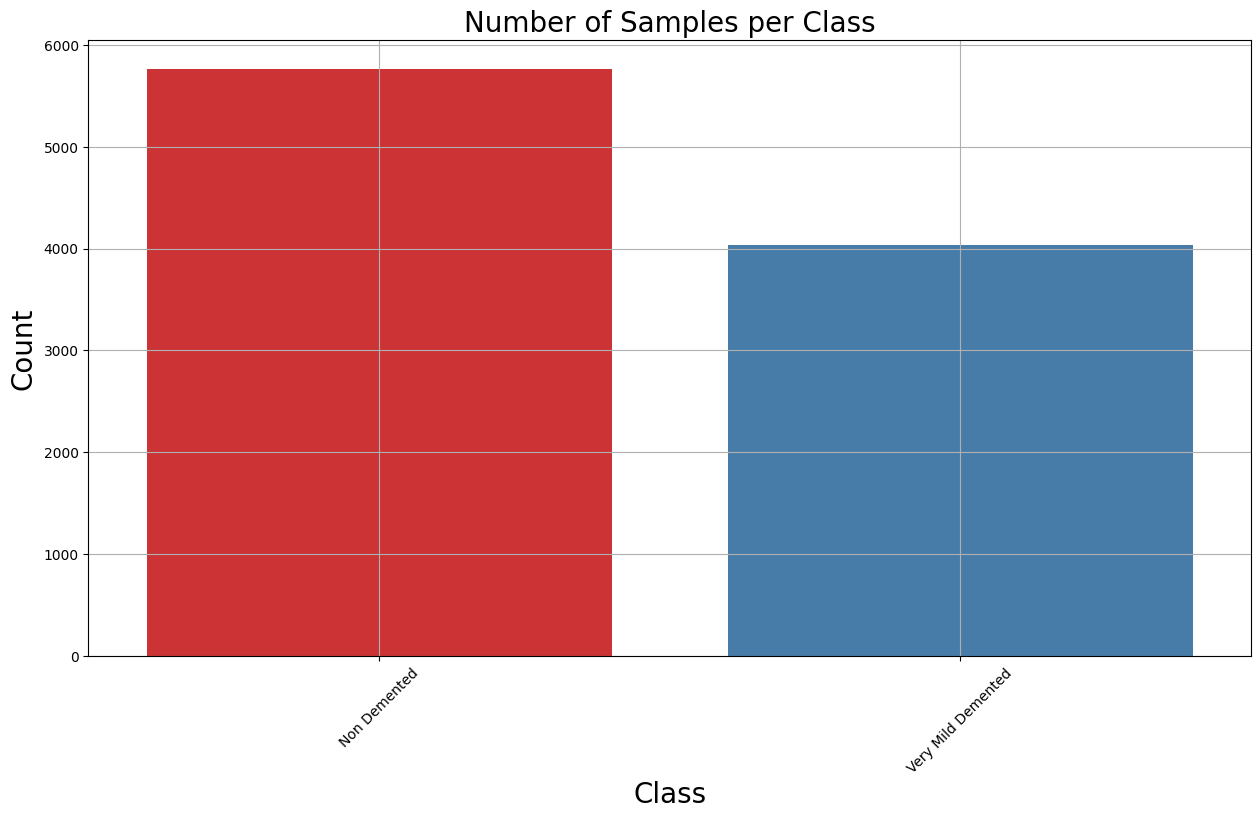

In [ ]:
# Plots the number of samples per class in the training set
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}

df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

plt.figure(figsize=(15,8))
sns.barplot(x=df["Class"], y=df["Count"], palette="Set1")
plt.xlabel("Class", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Number of Samples per Class", fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Builds and compiles the transfer learning model for training
model = build_transfer_learning_model(input_shape=(224, 224, 3), num_classes=2)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Displays a summary of the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Sets up early stopping and learning rate reduction callbacks for training
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

In [ ]:
# Trains the model with early stopping and learning rate scheduling, validating after each epoch
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


I0000 00:00:1746377233.747829      82 service.cc:148] XLA service 0x7b343c004020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746377233.750800      82 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746377235.979984      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/245 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5011 - loss: 0.8984   

I0000 00:00:1746377244.664642      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


245/245 ━━━━━━━━━━━━━━━━━━━━ 103s 318ms/step - accuracy: 0.6053 - loss: 0.6906 - val_accuracy: 0.6881 - val_loss: 0.5829 - learning_rate: 0.0010
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 61s 248ms/step - accuracy: 0.6735 - loss: 0.6001 - val_accuracy: 0.6974 - val_loss: 0.5733 - learning_rate: 0.0010
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 60s 243ms/step - accuracy: 0.6836 - loss: 0.5720 - val_accuracy: 0.7227 - val_loss: 0.5422 - learning_rate: 0.0010
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 58s 238ms/step - accuracy: 0.7187 - loss: 0.5340 - val_accuracy: 0.7399 - val_loss: 0.5116 - learning_rate: 0.0010
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 56s 229ms/step - accuracy: 0.7229 - loss: 0.5284 - val_accuracy: 0.6444 - val_loss: 0.6125 - learning_rate: 0.0010
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 56s 229ms/step - accuracy: 0.7281 - loss: 0.5204 - val_accuracy: 0.6951 - val_loss: 0.5547 - learning_rate: 0.0010
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 55s 225ms/step - accuracy: 0.7354 - loss

In [ ]:
# Optionally unfreezes the base model for fine-tuning
base_model = model.layers[2]
base_model.trainable = True

In [ ]:
# Recompiles the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Fine-tunes the model by continuing training with the base model unfrozen
fine_tune_epochs = 20
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 15/70
245/245 ━━━━━━━━━━━━━━━━━━━━ 94s 289ms/step - accuracy: 0.7337 - loss: 0.5133 - val_accuracy: 0.7054 - val_loss: 0.5338 - learning_rate: 1.0000e-05
Epoch 16/70
245/245 ━━━━━━━━━━━━━━━━━━━━ 59s 242ms/step - accuracy: 0.7380 - loss: 0.5130 - val_accuracy: 0.7054 - val_loss: 0.5400 - learning_rate: 1.0000e-05
Epoch 17/70
245/245 ━━━━━━━━━━━━━━━━━━━━ 59s 239ms/step - accuracy: 0.7411 - loss: 0.5085 - val_accuracy: 0.7054 - val_loss: 0.5423 - learning_rate: 1.0000e-05
Epoch 18/70
245/245 ━━━━━━━━━━━━━━━━━━━━ 64s 259ms/step - accuracy: 0.7382 - loss: 0.4991 - val_accuracy: 0.7066 - val_loss: 0.5414 - learning_rate: 1.0000e-05
Epoch 19/70
245/245 ━━━━━━━━━━━━━━━━━━━━ 58s 235ms/step - accuracy: 0.7406 - loss: 0.5025 - val_accuracy: 0.7020 - val_loss: 0.5457 - learning_rate: 1.0000e-05
Epoch 20/70
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7465 - loss: 0.4986
Epoch 20: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
245/245 ━━━━━━━━━━━━━━━━━━━━ 62s 

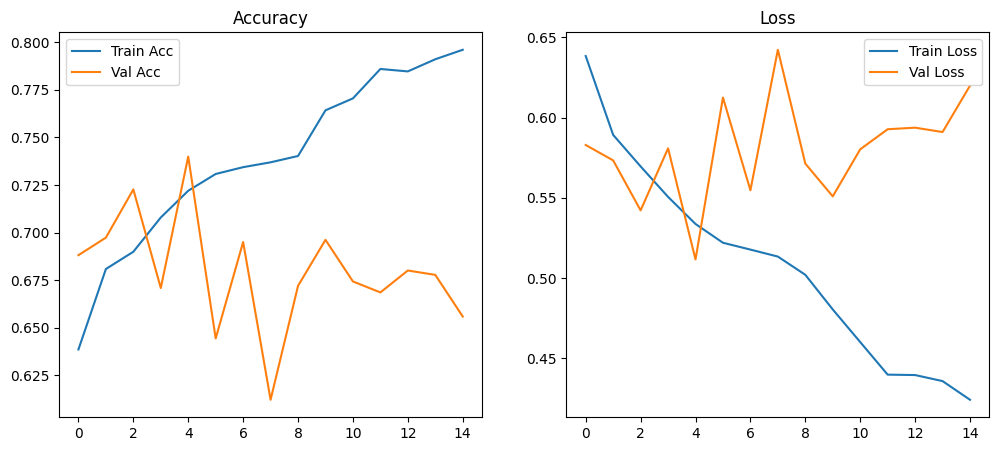

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step
              precision    recall  f1-score   support

     Healthy     0.6160    0.4272    0.5045       522
        Sick     0.4103    0.5994    0.4871       347

    accuracy                         0.4960       869
   macro avg     0.5131    0.5133    0.4958       869
weighted avg     0.5339    0.4960    0.4976       869



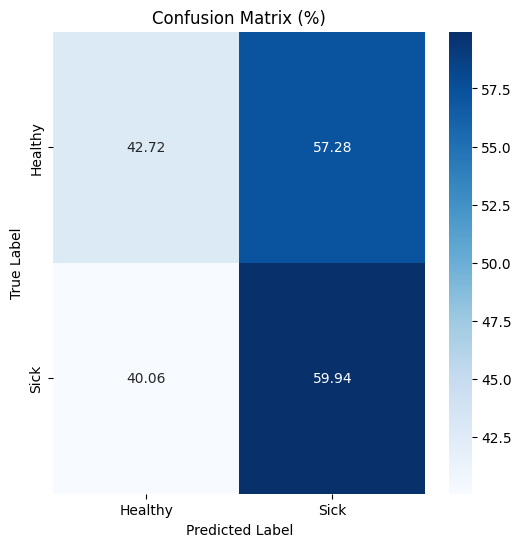

In [ ]:
# Plots training and validation metrics, evaluates and visualizes performance on the validation set
plot_training_history(history)

val_labels = np.concatenate([y.numpy() for x, y in val_ds])
val_preds = model.predict(val_ds)
val_pred_classes = np.argmax(val_preds, axis=1)
val_true_classes = np.argmax(val_labels, axis=1)

print(classification_report(val_true_classes, val_pred_classes, digits=4, target_names=class_names))

plot_confusion_matrix(val_true_classes, val_pred_classes, class_names)

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step

Test Classification Report:
              precision    recall  f1-score   support

     Healthy     0.7584    0.8094    0.7831       640
        Sick     0.6988    0.6317    0.6635       448

    accuracy                         0.7362      1088
   macro avg     0.7286    0.7205    0.7233      1088
weighted avg     0.7339    0.7362    0.7339      1088



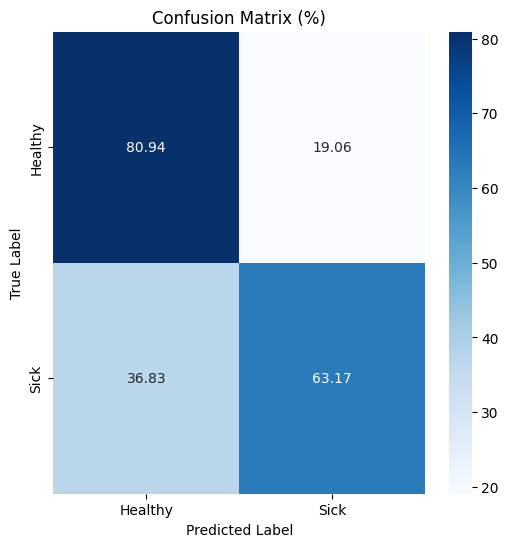

In [ ]:
# Evaluates model performance on the test set and displays metrics and confusion matrix
test_labels = np.concatenate([y.numpy() for x, y in test_ds])
test_preds = model.predict(test_ds)
test_pred_classes = np.argmax(test_preds, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

print("\nTest Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, digits=4, target_names=class_names))

plot_confusion_matrix(test_true_classes, test_pred_classes, class_names)